# **Imports and Parameters**
**Imports:**

*tensorflow:* Machine learning library.

*deepxde:* Deep learning library for solving differential equations.

*numpy:* Numerical computations.

*matplotlib.pyplot:* Plotting library for visualizations.

**Parameters:**

**rho:** Density of the fluid.

**mu:** Dynamic viscosity of the fluid.

**u_in:** Inlet velocity of the fluid.

**D:** Height of the rectangular domain.

**L:** Length of the rectangular domain.

In [17]:
import tensorflow as tf
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

In [4]:
rho = 1
mu = 1
u_in = 1
D = 1
L = 2

# **Geometry Definition**

Defines a rectangular domain with corners at [-L/2, -D/2] and [L/2, D/2].

In [5]:
geom = dde.geometry.Rectangle(xmin=[-L/2, -D/2], xmax=[L/2, D/2])

# **Boundary Conditions**
Boundary Condition Functions:
These functions determine where boundary conditions apply on the domain's edges.

**boundary_wall:** Checks if a point X is on the top or bottom wall (y = -D/2 or y = D/2).

**boundary_inlet:** Checks if a point X is at the inlet (x = -L/2).

**boundary_outlet:** Checks if a point X is at the outlet (x = L/2).

In [6]:
def boundary_wall(X, on_boundary):
    print("X",X)
    print("on_boundary",on_boundary)
    on_wall = np.logical_and(np.logical_or(np.isclose(X[1],-D/2,rtol=1e-05,atol=1e-08),np.isclose(X[1],D/2,rtol=1e-05,atol=1e-08)),on_boundary)
    return on_wall

def boundary_inlet(X,on_boundary):
    on_inlet = np.logical_and(np.isclose(X[0],-L/2,rtol=1e-05,atol=1e-08),on_boundary)
    return on_inlet

def boundary_outlet(X,on_boundary):
    on_outlet = np.logical_and(np.isclose(X[0],L/2,rtol=1e-05,atol=1e-08),on_boundary)
    return on_outlet

# **Dirichlet Boundary Conditions:**
These conditions specify fixed values on the boundaries.

**bc_wall_u and bc_wall_v:** Zero velocity (u=0, v=0) on the walls.

**bc_inlet_u and bc_inlet_v:** Prescribed inlet velocity (u=u_in, v=0).

**bc_outlet_p:** Zero pressure at the outlet.

**bc_outlet_v:**  Zero vertical velocity at the outlet.

In [7]:
bc_wall_u = dde.DirichletBC(geom, lambda X:0., boundary_wall, component= 0)
bc_wall_v = dde.DirichletBC(geom, lambda X:0., boundary_wall, component= 1)

bc_inlet_u = dde.DirichletBC(geom, lambda X:u_in, boundary_inlet, component= 0)
bc_inlet_v = dde.DirichletBC(geom, lambda X:0.   , boundary_inlet, component= 1)

bc_outlet_p = dde.DirichletBC(geom, lambda X:0.  , boundary_outlet, component= 2)
bc_outlet_v = dde.DirichletBC(geom, lambda X:0.  , boundary_outlet, component= 1)


# **PDE Definition**
PDE Function:
Defines the system of PDEs.

*Y represents the output of the neural network, which has three components: u, v, and p (velocity components and pressure).*

**du_x, du_y,** etc., compute partial derivatives (Jacobian and Hessian) of u, v, and p with respect to x and y.

**pde_u and pde_v:** Equations for the momentum in u and v directions.

**pde_cont:**  Continuity equation ensuring mass conservation.

Returns the residuals of the PDEs which the network aims to minimize.

In [8]:
def pde(X,Y):
    du_x =dde.grad.jacobian(Y, X, i=0, j=0)
    du_y =dde.grad.jacobian(Y, X, i=0, j=1)
    dv_x =dde.grad.jacobian(Y, X, i=1, j=0)
    dv_y =dde.grad.jacobian(Y, X, i=1, j=1)
    dp_x =dde.grad.jacobian(Y, X, i=2, j=0)
    dp_y =dde.grad.jacobian(Y, X, i=2, j=1)

    du_xx = dde.grad.hessian(Y, X, component=0, i=0, j=0)
    du_yy = dde.grad.hessian(Y, X, component=0, i=1, j=1)
    dv_xx = dde.grad.hessian(Y, X, component=1, i=0, j=0)
    dv_yy = dde.grad.hessian(Y, X, component=1, i=1, j=1)

    pde_u    = Y[:,0:1]*du_x +  Y[:,1:2]*du_y + 1/rho * dp_x - (mu/rho) * (du_xx+ du_yy)
    pde_v    = Y[:,0:1]*dv_x +  Y[:,1:2]*dv_y + 1/rho * dp_y - (mu/rho) * (dv_xx+ dv_yy)
    pde_cont = du_x + dv_y

    return [pde_u,pde_v,pde_cont]

# **Data Preparation**
Data Setup:

**data:** Initializes the PDE problem with the geometry, PDE function, boundary conditions, and sample points.

**num_domain:** Number of training points in the domain.

**num_boundary:** Number of training points on the boundary.

**num_test:** Number of test points for evaluating the solution.

The plot visualizes the training points within the domain.

In [9]:
data = dde.data.PDE(geom,
                   pde,
                   [bc_wall_u,bc_wall_v,bc_inlet_u,bc_inlet_v,bc_outlet_p,bc_outlet_v],
                   num_domain  = 2000,
                   num_boundary= 200,
                   num_test = 200)

Streaming output truncated to the last 5000 lines.
X [0.2919922  0.35007495]
on_boundary False
X [-0.20800781  0.35057473]
on_boundary False
X [0.7919922  0.35107446]
on_boundary False
X [-0.8330078   0.35157424]
on_boundary False
X [0.16699219 0.35207397]
on_boundary False
X [-0.3330078  0.3525737]
on_boundary False
X [0.6669922  0.35307348]
on_boundary False
X [-0.5830078  0.3535732]
on_boundary False
X [0.4169922 0.354073 ]
on_boundary False
X [-0.08300781  0.3545727 ]
on_boundary False
X [0.9169922  0.35507244]
on_boundary False
X [-0.8955078   0.35557222]
on_boundary False
X [0.10449219 0.35607195]
on_boundary False
X [-0.3955078   0.35657173]
on_boundary False
X [0.6044922  0.35707146]
on_boundary False
X [-0.6455078   0.35757118]
on_boundary False
X [0.3544922  0.35807097]
on_boundary False
X [-0.14550781  0.3585707 ]
on_boundary False
X [0.8544922  0.35907048]
on_boundary False
X [-0.7705078  0.3595702]
on_boundary False
X [0.22949219 0.36007   ]
on_boundary False
X [-0.2705078

# **Scatter Plot**

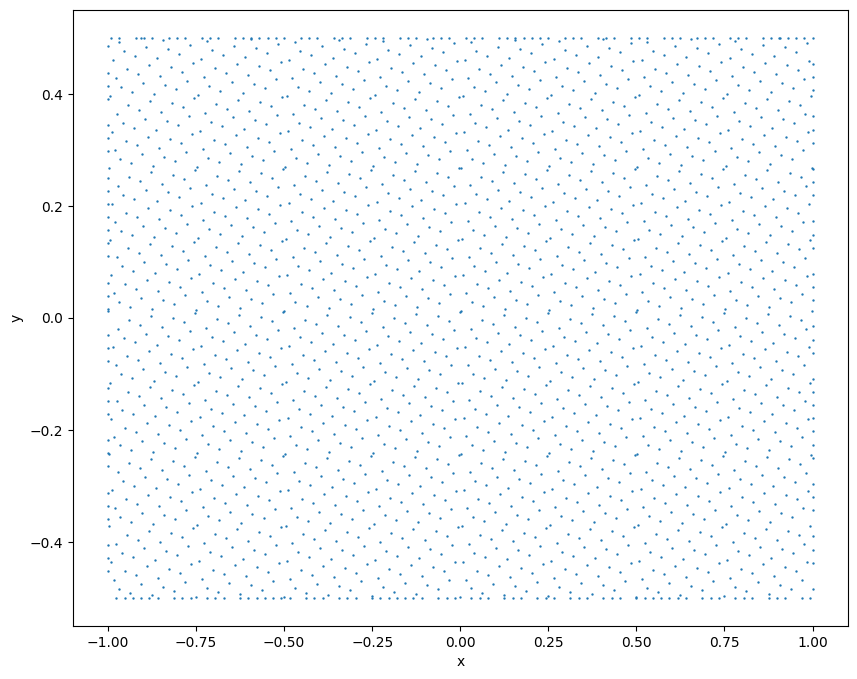

In [10]:
plt.figure(figsize=(10,8))
plt.scatter(data.train_x_all[:,0], data.train_x_all[:,1], s= 0.5)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# **Neural Network Definition**
*Neural Network:*

**net:** Defines a fully connected neural network (Feedforward Neural Network) with:

**Input layer:** 2 neurons (for x and y).

**Hidden layers:** 5 layers, each with 64 neurons.

**Output layer:** 3 neurons (for u, v, and p).

**Activation function:** tanh.

**Weight initialization:** Glorot uniform.

In [11]:
net = dde.maps.FNN([2] + [64]*5 + [3] , "tanh", "Glorot uniform")

# **Model Compilation and Training**
Model Initialization and Training:

**model:** Combines the PDE data and the neural network.

First compile using the Adam optimizer with a learning rate of 0.001.

Train the model for 10,000 epochs with Adam optimizer.

Recompile using the L-BFGS optimizer for further fine-tuning.

Train the model with L-BFGS. italicized text

**saveplot:** Saves and plots the training history, though issave and isplot are set to False.

In [12]:
model = dde.Model(data, net)
model.compile("adam",lr=1e-3)

Compiling model...
Building feed-forward neural network...
'build' took 0.113792 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 2.103790 s



In [14]:
losshistory, train_state = model.train(epochs = 2000)

Training model...

2844      [7.25e-03, 4.71e-03, 4.07e-03, 2.01e-02, 1.05e-02, 2.31e-02, 1.62e-03, 1.11e-03, 2.42e-04]    [5.02e-03, 4.70e-03, 2.66e-03, 2.01e-02, 1.05e-02, 2.31e-02, 1.62e-03, 1.11e-03, 2.42e-04]    []  
3000      [9.34e-03, 1.56e-03, 3.32e-03, 1.82e-02, 1.02e-02, 2.34e-02, 1.95e-03, 5.43e-03, 1.48e-05]    [9.03e-03, 1.10e-03, 1.89e-03, 1.82e-02, 1.02e-02, 2.34e-02, 1.95e-03, 5.43e-03, 1.48e-05]    []  
4000      [9.44e-03, 6.43e-03, 3.29e-03, 1.64e-02, 9.13e-03, 1.91e-02, 3.40e-03, 2.99e-04, 1.20e-04]    [6.51e-03, 5.31e-03, 1.59e-03, 1.64e-02, 9.13e-03, 1.91e-02, 3.40e-03, 2.99e-04, 1.20e-04]    []  
4844      [3.34e-04, 4.26e-04, 3.06e-03, 1.59e-02, 8.33e-03, 1.70e-02, 4.09e-03, 2.39e-05, 1.51e-05]    [2.53e-04, 2.07e-04, 1.26e-03, 1.59e-02, 8.33e-03, 1.70e-02, 4.09e-03, 2.39e-05, 1.51e-05]    []  

Best model at step 4844:
  train loss: 4.92e-02
  test loss: 4.71e-02
  test metric: []

'train' took 309.830616 s



In [15]:
dde.optimizers.config.set_LBFGS_options(maxiter= 3000)
model.compile("L-BFGS")
losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave=False, isplot=False)

Compiling model...
'compile' took 1.409784 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
4844      [3.34e-04, 4.26e-04, 3.06e-03, 1.59e-02, 8.33e-03, 1.70e-02, 4.09e-03, 2.39e-05, 1.51e-05]    [2.53e-04, 2.07e-04, 1.26e-03, 1.59e-02, 8.33e-03, 1.70e-02, 4.09e-03, 2.39e-05, 1.51e-05]    []  
5000      [3.84e-04, 3.55e-04, 2.36e-03, 1.41e-02, 3.96e-03, 1.50e-02, 5.54e-03, 1.28e-05, 3.59e-05]    [3.84e-04, 3.55e-04, 2.36e-03, 1.41e-02, 3.96e-03, 1.50e-02, 5.54e-03, 1.28e-05, 3.59e-05]        
6000      [9.72e-04, 8.97e-04, 1.50e-03, 8.06e-03, 1.50e-03, 5.46e-03, 2.18e-03, 1.73e-05, 2.66e-06]    [9.72e-04, 8.97e-04, 1.50e-03, 8.06e-03, 1.50e-03, 5.46e-03, 2.18e-03, 1.73e-05, 2.66e-06]        
7000      [3.22e-04, 5.65e-04, 5.60e-04, 5.14e-03, 8.62e-04, 4.77e-03, 1.65e-03, 2.24e-05, 9.89e-06]    [3.22e-04, 5

# **Prediction and Visualization**
Prediction and Plotting:

**samples:** Generates 500,000 random points within the domain for prediction.

**result:** Predicts the solution (u, v, and p) at the sampled points.

The loop plots the predicted u, v, and p with a color map (jet) and adjusts the color limits based on color_legend.

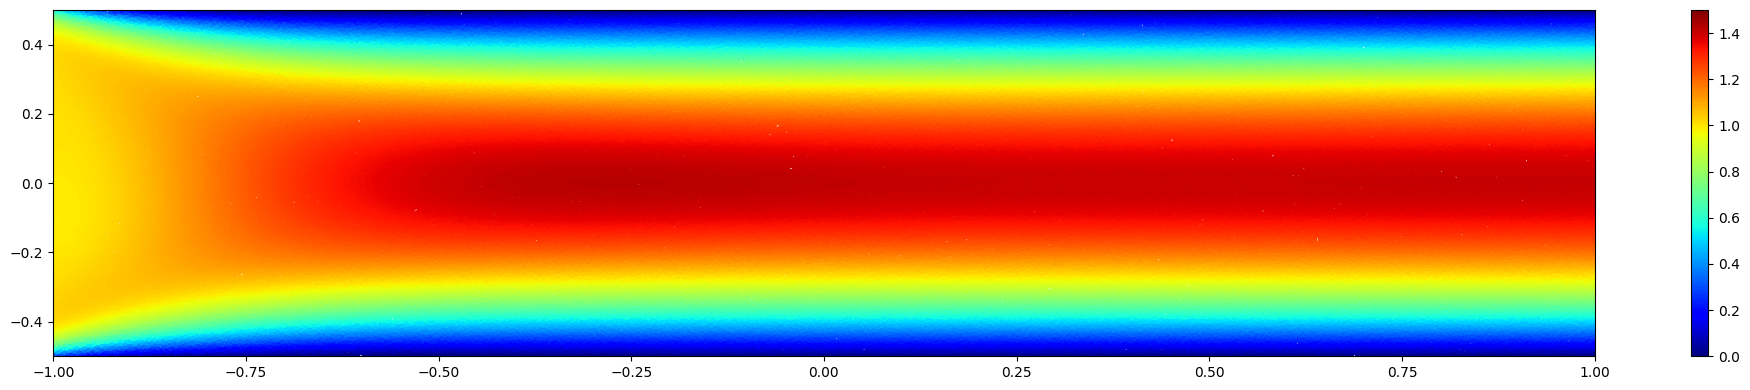

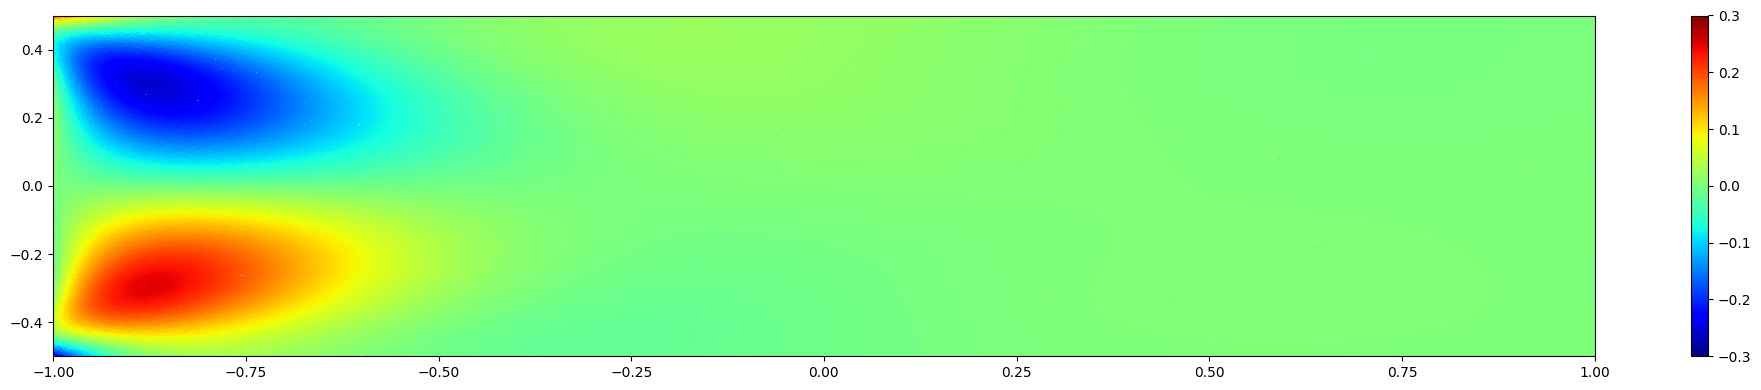

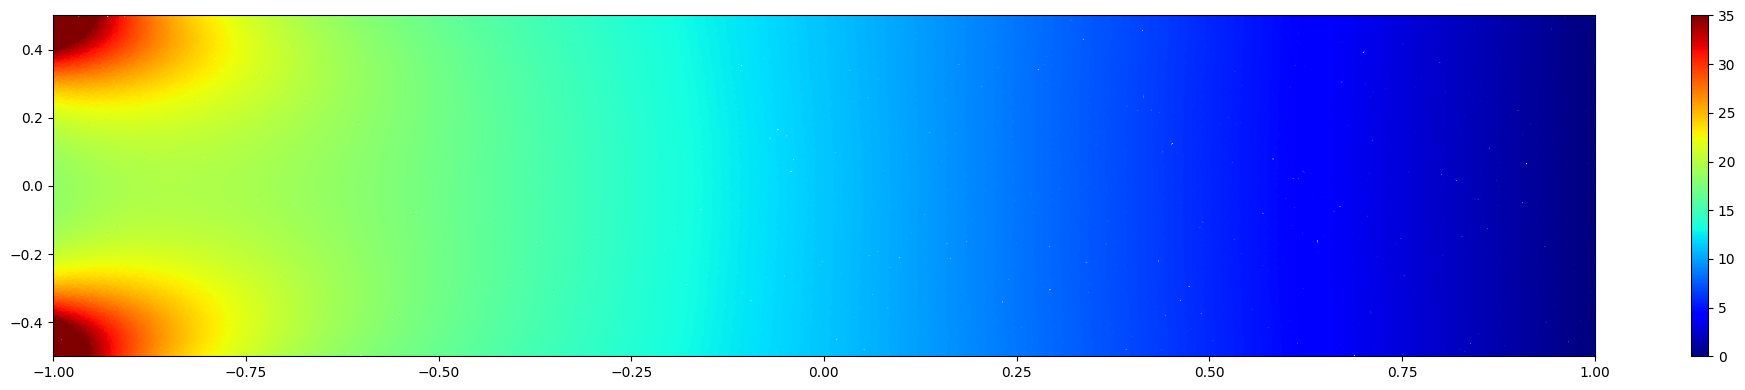

In [16]:
samples = geom.random_points(500000)
result = model.predict(samples)
color_legend = [[0,1.5],[-0.3,0.3],[0,35]]

for idx in range(3):
    plt.figure(figsize=(20,4))
    plt.scatter(samples[:,0], samples[:,1], c=result[:,idx], cmap='jet', s=2)
    plt.colorbar()
    plt.clim(color_legend[idx])
    plt.xlim((0 - L/2, L - L/2))
    plt.ylim((0 - D/2, D - D/2))
    plt.tight_layout()
    plt.show()

# **Summary:**

**Initial Conditions:** Not explicitly specified, but usually, the initial guess is zero or random values.

**Boundary Conditions:** Defined using DirichletBC for velocity and pressure on different parts of the boundary.

**Loss Function:** Implicitly defined by the residuals of the PDE and boundary conditions, which the model minimizes.

**Optimizer:** Starts with Adam, then switches to L-BFGS for better convergence.

**Training:** First uses Adam for a large number of epochs, followed by L-BFGS for optimization.

**Testing and Evaluation:** Conducted on num_test points and additional random samples, with results visualized via scatter plots.